In [ ]:
!pip install tabulate

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
from tabulate import tabulate

import tensorflow as tf
from tensorflow import keras
import tensorflow_probability as tfp

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, mean_squared_log_error, r2_score


#**Functions**

In [ ]:
# Devuelve el código que permite inicializarlos
def _get_random_features_initializer(initializer, shape,seed):
    def _get_cauchy_samples(loc, scale, shape):
        np.random.seed(seed)
        probs = np.random.uniform(low=0., high=1., size=shape)
        return loc + scale * np.tan(np.pi * (probs - 0.5))

    if isinstance(initializer,str):
        if initializer == "gaussian":
            return tf.keras.initializers.RandomNormal(stddev=1.0,seed=seed)
        elif initializer == "laplacian":
            return tf.keras.initializers.Constant(
                _get_cauchy_samples(loc=0.0, scale=1.0, shape=shape))
        else:
            raise ValueError(f'Unsupported kernel initializer {initializer}')

In [ ]:
class Conv1dRFF(tf.keras.layers.Layer):

    # Contructor
    def __init__(self, output_dim, kernel_size=3, scale=None, padding='VALID', data_format='NWC', normalization=True, function=True,
                 trainable_scale=False, trainable_W=False,
                 seed=None, kernel='gaussian',
                 **kwargs):

        super(Conv1dRFF, self).__init__(**kwargs)

        self.output_dim=output_dim                  # Output dimension
        self.kernel_size=kernel_size                # Convolutional operation size
        self.scale=scale                            # Kernel gaussian
        self.padding=padding                        #
        self.data_format=data_format                # Format of operation convolutional
        self.normalization=normalization,           #
        self.function=function                      # sine or cosine
        self.trainable_scale=trainable_scale        #
        self.trainable_W=trainable_W                #
        self.seed=seed                              # Type of kernel
        self.initializer=kernel

    # ----------------------------------------------------------------------
    def get_config(self):
        config = super().get_config().copy()
        config.update({
            'output_dim': self.output_dim,
            'kernel_size': self.kernel_size,
            'scale': self.scale,
            'padding': self.padding,
            'data_format': self.data_format,
            'normalization': self.normalization,
            'function': self.function,
            'trainable': self.trainable,
            'trainable_scale':self.trainable_scale,
            'trainable_W':self.trainable_W,
            'seed':self.seed
        })
        return config

    # ----------------------------------------------------------------------
    def build(self, input_shape):

        input_dim = input_shape[-1]
        #kernel_initializer = tf.random_normal_initializer(stddev=1.0)

        kernel_initializer = _get_random_features_initializer(self.initializer,
                                                              shape=(self.kernel_size,self.kernel_size,
                                                              input_dim,
                                                              self.output_dim),
                                                              seed=self.seed)

        # Inicializador de los valores de la operación convolucional (kernel)
        self.kernel = self.add_weight(
            name='kernel',
            shape=(self.kernel_size, input_shape[-1], self.output_dim),
            dtype=tf.float32,
            initializer=kernel_initializer,
            trainable=self.trainable_W
        )
        # Incilización de los pesos del bias
        """
          Pendiente de revisar la configuración del parametro initializer
        """
        self.bias = self.add_weight(
            name='bias',
            shape=(self.output_dim,),
            dtype=tf.float32,
            initializer=tf.random_uniform_initializer(minval=0.0, maxval=2*np.pi, seed=self.seed),
            trainable=self.trainable_W
        )
        # Inicializador de ancho de banda del kernel
        if not self.scale:
            if  self.initializer == 'gaussian':
                self.scale = np.sqrt((input_dim*self.kernel_size**2)/2.0)
                #print(self.scale)
            elif self.initializer == 'laplacian':
                self.scale = 1.0
            else:
                raise ValueError(f'Unsupported kernel initializer {self.initializer}')
        #
        self.kernel_scale = self.add_weight(
            name='kernel_scale',
            shape=(1,),
            dtype=tf.float32,
            initializer=tf.compat.v1.constant_initializer(self.scale),
            trainable=self.trainable_scale,
            constraint='NonNeg'
        )

    # ----------------------------------------------------------------------
    def call(self, inputs):

        scale = tf.math.divide(1.0, self.kernel_scale)
        kernel = tf.math.multiply(scale, self.kernel)

        inputs = tf.convert_to_tensor(inputs, dtype=tf.float32)
        inputs = tf.cast(inputs, tf.float32)

        outputs = tf.nn.conv1d(inputs, kernel, stride=1, padding=self.padding, data_format=self.data_format)
        outputs = tf.nn.bias_add(outputs, self.bias)

        if self.normalization:
            if self.function:
                outputs = tf.math.multiply(tf.math.sqrt(2/self.output_dim),tf.cos(outputs))
            else:
                outputs = tf.where(tf.equal(tf.math.mod(outputs, 2), 0), tf.math.multiply(tf.math.sqrt(2/self.output_dim), tf.cos(outputs)), tf.math.multiply(tf.math.sqrt(2/self.output_dim), tf.sin(outputs)))
        else:
            if self.function:
                outputs = tf.cos(outputs)
            else:
                outputs = tf.where(tf.equal(tf.math.mod(outputs, 2), 0), tf.cos(outputs), tf.math.sqrt(2/self.output_dim), tf.sin(outputs))

        return outputs

#**Dataset**

## Parameters

In [ ]:
col_names, MSE, RMSE, MAE, R2 = ['Model'], ["MSE"], ["RMSE"], ["MAE"], ["R2"]

In [ ]:
window = 15
kernel_size = 3
epochs = 500
output_dim = 1000


## Creation

In [ ]:
# Parameters: Lorenz systems
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0
num_steps = 100000
dt = 0.01

# Variables Initialization
x, y, z = np.zeros(num_steps), np.zeros(num_steps), np.zeros(num_steps)

# Initial conditions
x[0], y[0], z[0] = 0.0, 1.0, 20.0

# Add noise
std = 3
mu = 0.1

for i in range(1, num_steps):
    x_dot = sigma * (y[i - 1] - x[i - 1])
    y_dot = x[i - 1] * (rho - z[i - 1]) - y[i - 1]
    z_dot = x[i - 1] * y[i - 1] - beta * z[i - 1]

    x[i] = x[i - 1] + x_dot * dt
    y[i] = y[i - 1] + y_dot * dt
    z[i] = z[i - 1] + z_dot * dt


noise = np.random.normal(mu, std, size=num_steps)
timeserie = x + noise


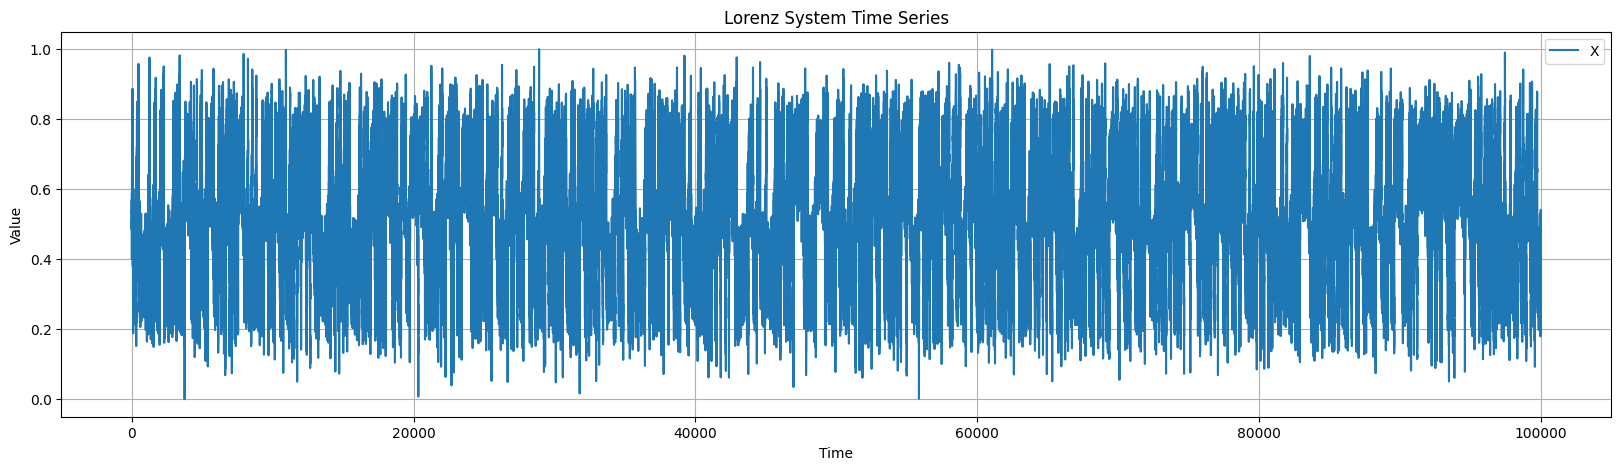

In [ ]:
# Normalization
timeserieNormalized = (timeserie-min(timeserie))/(max(timeserie)-min(timeserie))

plt.figure(figsize=(20, 5))
plt.plot(timeserieNormalized, label='X')
plt.title('Lorenz System Time Series')
plt.xlabel('Time'); plt.ylabel('Value')
plt.legend()
plt.grid(True)
plt.show()

## Train, test, value

In [ ]:
X = np.zeros([len(timeserieNormalized)-window, window])
for i in range(len(timeserieNormalized)-window):
  X[i,:] = timeserieNormalized[i:i+window].T
# Vector de salida (pronostico de nuestro modelo)
y = timeserieNormalized[window:]

X = X[:,:, np.newaxis]

X.shape, y.shape

((99985, 15, 1), (99985,))

In [ ]:
X_, X_test, y_, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X_, y_, test_size=0.2, random_state=42)

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape, X_test.shape, y_test.shape

((63990, 15, 1), (63990,), (15998, 15, 1), (15998,), (19997, 15, 1), (19997,))

#**Forecasting**

## Convolutional 1d

In [ ]:
input = tf.keras.layers.Input(shape=(X_train.shape[1], 1), name='Input')

tmp = tf.keras.layers.Conv1D(filters=64, kernel_size=3, activation='relu', name='Convolutional')(input)
tmp = tf.keras.layers.MaxPooling1D(pool_size=2,name='Max_pooling')(tmp)
tmp = tf.keras.layers.Flatten(name='Flatten')(tmp)
tmp = tf.keras.layers.Dense(64, activation='relu',name='Dense')(tmp)
output = tf.keras.layers.Dense(1, activation='linear', name='Output')(tmp)

model = tf.keras.Model(inputs=input, outputs=output)
model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 Convolutional (Conv1D)      (None, 13, 64)            256       
                                                                 
 Max_pooling (MaxPooling1D)  (None, 6, 64)             0         
                                                                 
 Flatten (Flatten)           (None, 384)               0         
                                                                 
 Dense (Dense)               (None, 64)                24640     
                                                                 
 Output (Dense)              (None, 1)                 65        
                                                                 
Total params: 24961 (97.50 KB)
Trainable params: 24961 (97.

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit(X_train, y_train, epochs=epochs, batch_size=1024, validation_data=(X_valid, y_valid), verbose=0)

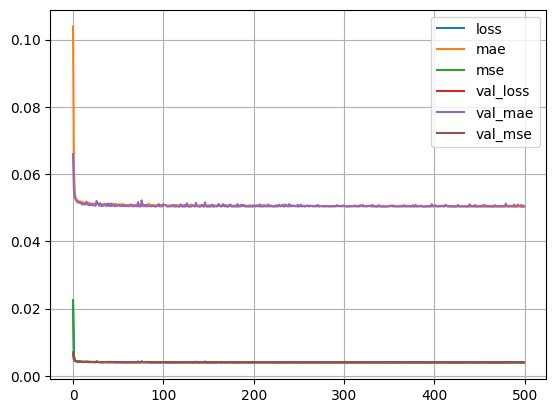

In [ ]:
hpd = pd.DataFrame(history.history)

hpd.plot()
plt.grid(True)
plt.show()

625/625 [==============================] - 1s 2ms/step


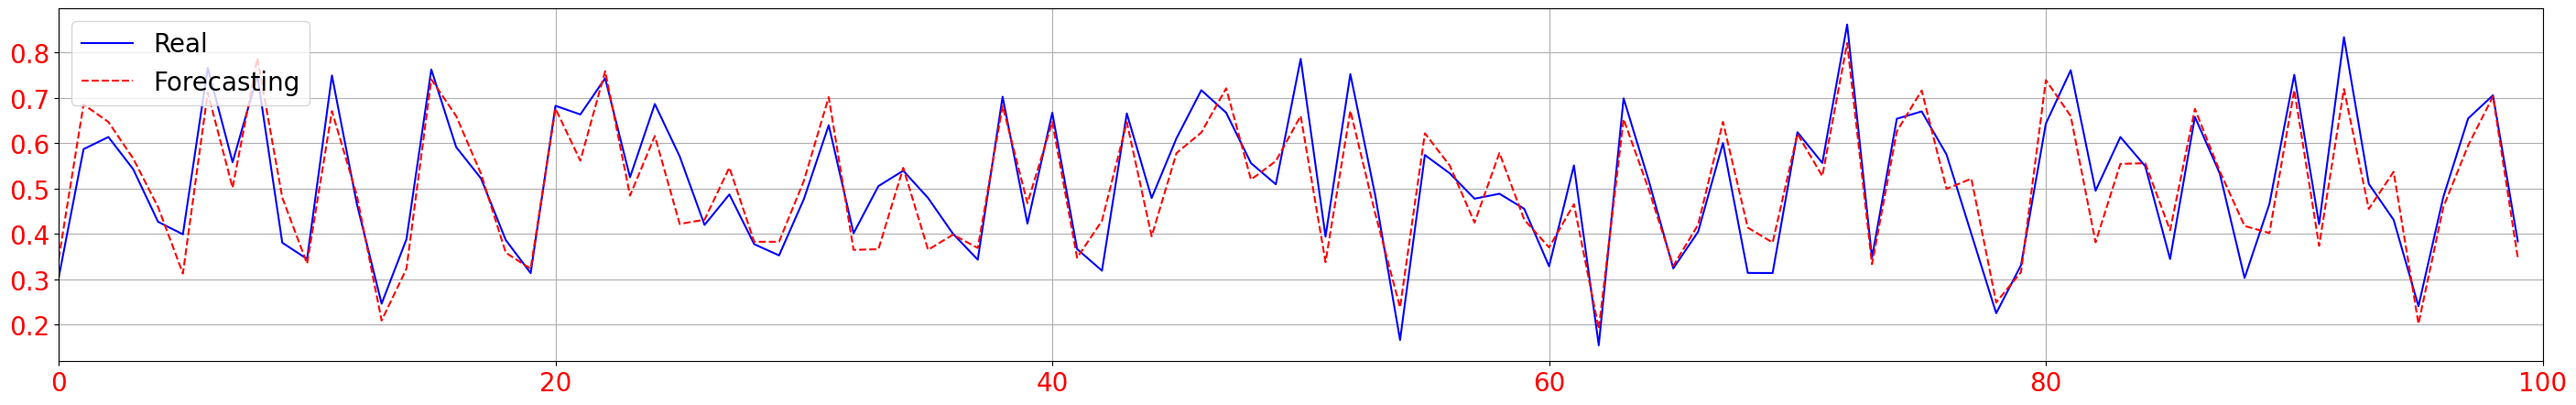

In [ ]:
forecasting_CNN1d = model.predict(X_test)

plt.figure(figsize=(35,5))
plt.plot(y_test[0:100], c='b', label='Real')
plt.plot(forecasting_CNN1d[0:100], c='r', label='Forecasting', linestyle='--')
plt.xlim(0,100)
plt.xticks(c='r', fontsize="20")
plt.yticks(c='r', fontsize="20")
plt.grid(True)
plt.legend(fontsize="20", loc="upper left")
plt.show()

In [ ]:
col_names.append("CNN 1d")
MSE.append(round(mean_squared_error(y_test, forecasting_CNN1d, squared=False), 3))
RMSE.append(round(mean_squared_error(y_test, forecasting_CNN1d, squared=True), 3))
MAE.append(round(mean_absolute_error(y_test, forecasting_CNN1d), 3))
R2.append(round(r2_score(y_test, forecasting_CNN1d), 3))

## RFF Convolutional 1d: W=False, scale=False

In [ ]:
input = tf.keras.layers.Input(shape=(X_train.shape[1],1), name='Input')

tmp = Conv1dRFF(output_dim, kernel_size=kernel_size, trainable_W=False, trainable_scale=False)(input)
tmp = tf.keras.layers.Flatten()(tmp)
tmp = tf.keras.layers.Dense(units=64, activation='relu',name='Dense_1')(tmp)
output = tf.keras.layers.Dense(units=1, activation='linear')(tmp)

model = tf.keras.Model(inputs=input, outputs=output)
model.summary()


Model: "model_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 conv1d_rff_4 (Conv1dRFF)    (None, 13, 1000)          4001      
                                                                 
 flatten_4 (Flatten)         (None, 13000)             0         
                                                                 
 Dense_1 (Dense)             (None, 64)                832064    
                                                                 
 dense_4 (Dense)             (None, 1)                 65        
                                                                 
Total params: 836130 (3.19 MB)
Trainable params: 832129 (3.17 MB)
Non-trainable params: 4001 (15.63 KB)
_________________________________________________________________


In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit(X_train, y_train, epochs=epochs, batch_size=1024, validation_data=(X_valid, y_valid), verbose=0)

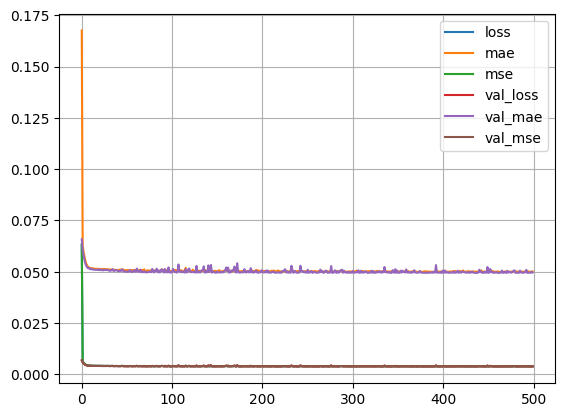

In [ ]:
hpd = pd.DataFrame(history.history)

hpd.plot()
plt.grid(True)
plt.show()

625/625 [==============================] - 1s 2ms/step


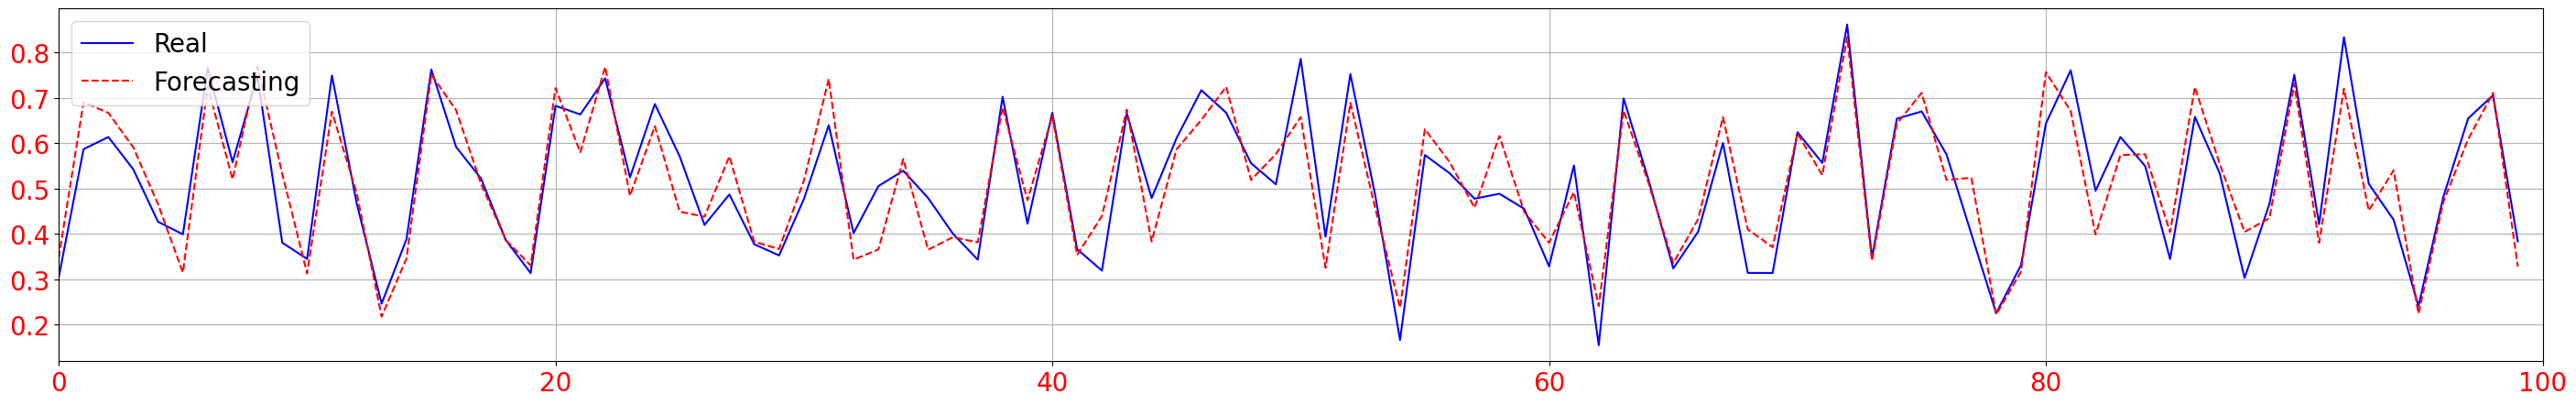

In [ ]:
forecasting_RFF_CNN1d = model.predict(X_test)

plt.figure(figsize=(35,5))
plt.plot(y_test[0:100], c='b', label='Real')
plt.plot(forecasting_RFF_CNN1d[0:100], c='r', label='Forecasting', linestyle='--')
plt.xlim(0,100)
plt.xticks(c='r', fontsize="20")
plt.yticks(c='r', fontsize="20")
plt.grid(True)
plt.legend(fontsize="20", loc="upper left")
plt.show()

In [ ]:
col_names.append("RFF-CNN 1d W=False scale=False")
MSE.append(round(mean_squared_error(y_test, forecasting_RFF_CNN1d, squared=False), 4))
RMSE.append(round(mean_squared_error(y_test, forecasting_RFF_CNN1d, squared=True), 4))
MAE.append(round(mean_absolute_error(y_test, forecasting_RFF_CNN1d), 4))
R2.append(round(r2_score(y_test, forecasting_RFF_CNN1d), 4))

## RFF Convolutional 1d: W=False, scale=True

In [ ]:
input = tf.keras.layers.Input(shape=(X_train.shape[1],1), name='Input')

tmp = Conv1dRFF(output_dim, kernel_size=kernel_size, trainable_W=False, trainable_scale=True)(input)
tmp = tf.keras.layers.Flatten()(tmp)
tmp = tf.keras.layers.Dense(units=64, activation='relu',name='Dense_1')(tmp)
output = tf.keras.layers.Dense(units=1, activation='linear')(tmp)

model = tf.keras.Model(inputs=input, outputs=output)
model.summary()


Model: "model_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 conv1d_rff_5 (Conv1dRFF)    (None, 13, 1000)          4001      
                                                                 
 flatten_5 (Flatten)         (None, 13000)             0         
                                                                 
 Dense_1 (Dense)             (None, 64)                832064    
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 836130 (3.19 MB)
Trainable params: 832130 (3.17 MB)
Non-trainable params: 4000 (15.62 KB)
_________________________________________________________________
Model: "model_11"
___

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit(X_train, y_train, epochs=epochs, batch_size=1024, validation_data=(X_valid, y_valid), verbose=0)

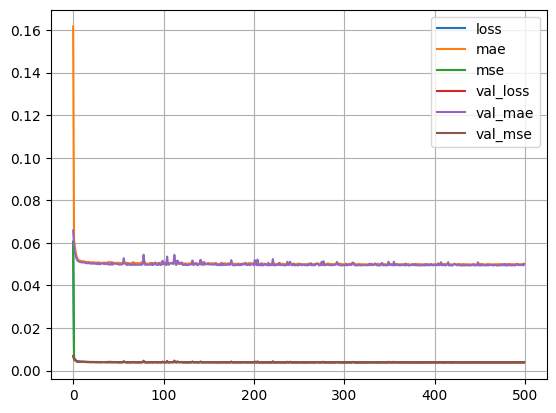

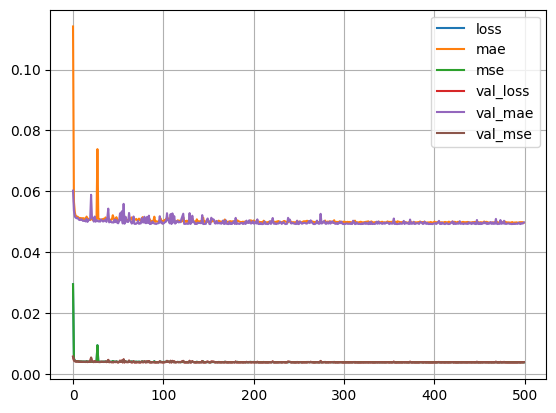

In [ ]:
hpd = pd.DataFrame(history.history)

hpd.plot()
plt.grid(True)
plt.show()

625/625 [==============================] - 2s 2ms/step


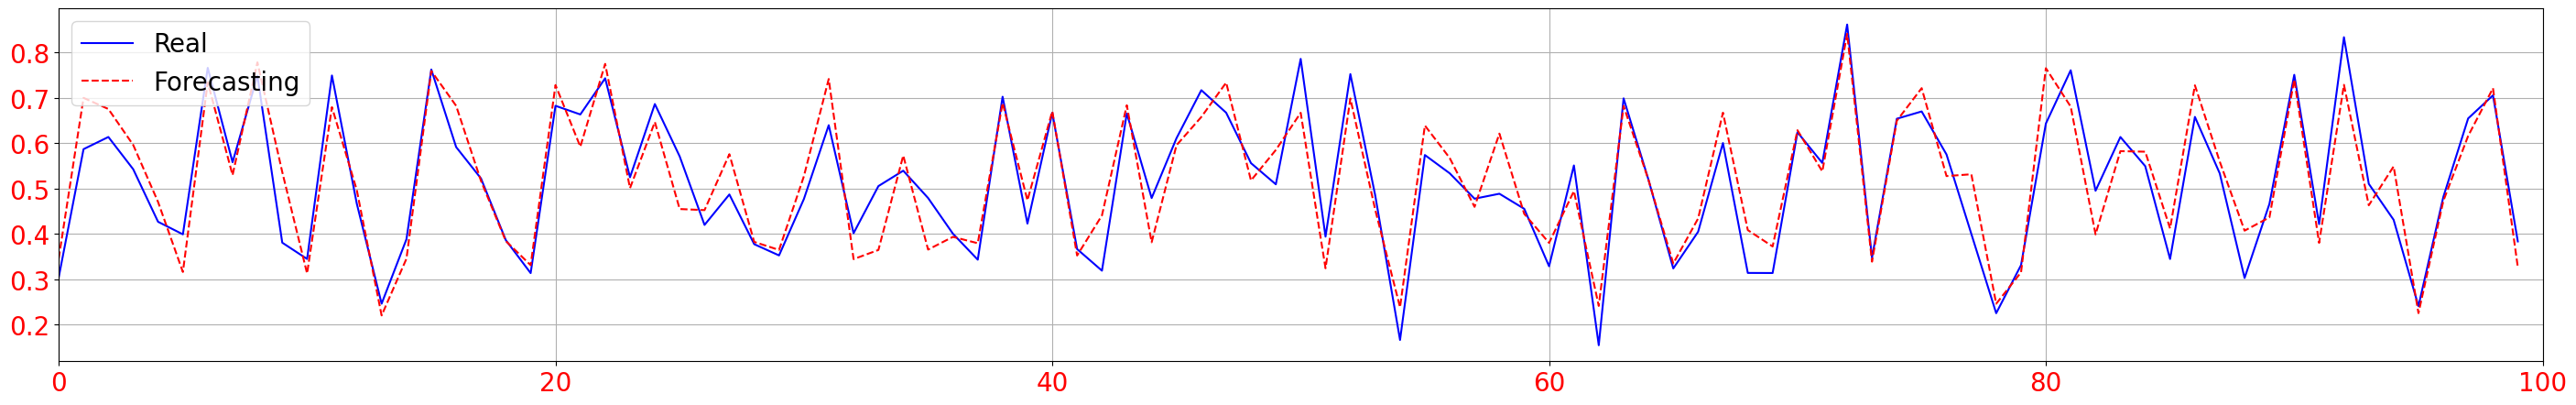

625/625 [==============================] - 1s 2ms/step


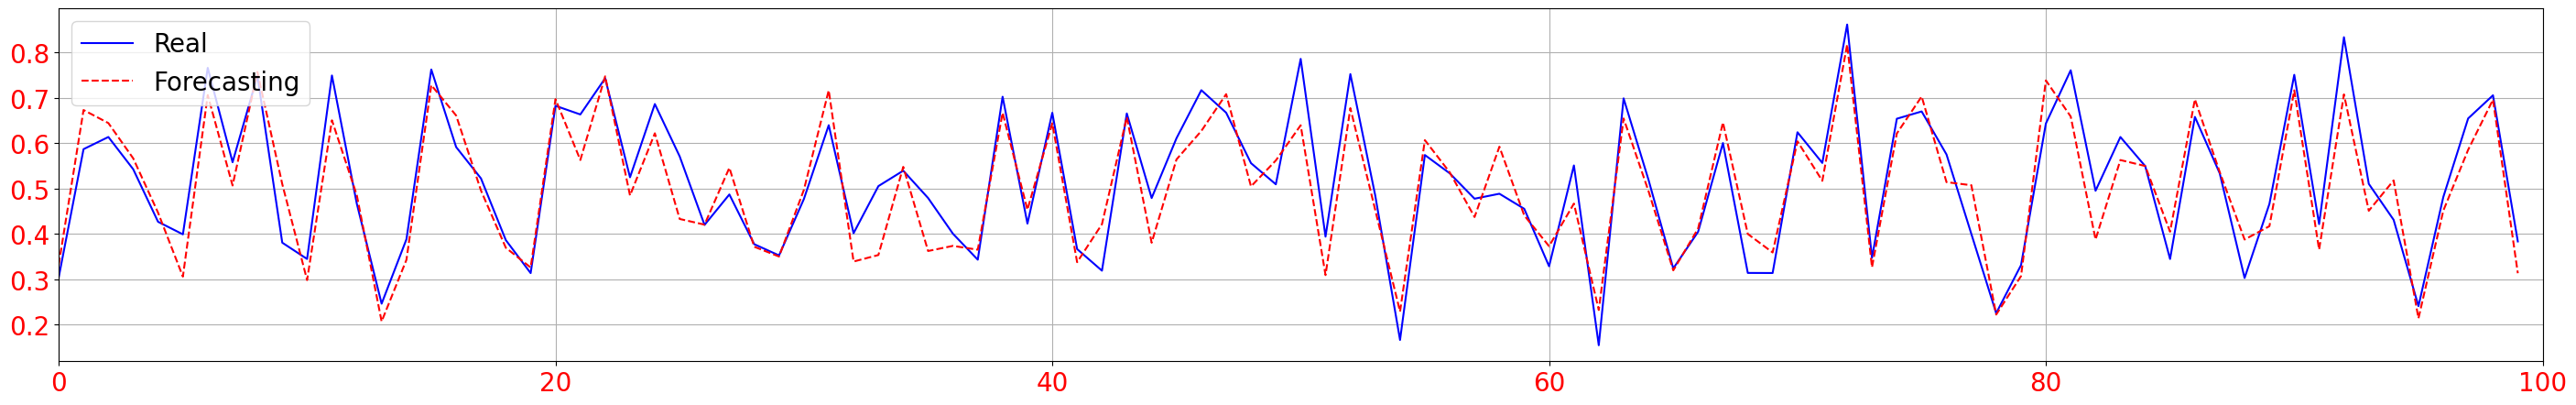

In [ ]:
forecasting_RFF_CNN1d = model.predict(X_test)

plt.figure(figsize=(35,5))
plt.plot(y_test[0:100], c='b', label='Real')
plt.plot(forecasting_RFF_CNN1d[0:100], c='r', label='Forecasting', linestyle='--')
plt.xlim(0,100)
plt.xticks(c='r', fontsize="20")
plt.yticks(c='r', fontsize="20")
plt.grid(True)
plt.legend(fontsize="20", loc="upper left")
plt.show()

In [ ]:
col_names.append("RFF-CNN 1d W=False scale=True")
MSE.append(round(mean_squared_error(y_test, forecasting_RFF_CNN1d, squared=False), 4))
RMSE.append(round(mean_squared_error(y_test, forecasting_RFF_CNN1d, squared=True), 4))
MAE.append(round(mean_absolute_error(y_test, forecasting_RFF_CNN1d), 4))
R2.append(round(r2_score(y_test, forecasting_RFF_CNN1d), 4))

## RFF Convolutional 1d: W=True, scale=False

In [ ]:
input = tf.keras.layers.Input(shape=(X_train.shape[1],1), name='Input')

tmp = Conv1dRFF(output_dim, kernel_size=kernel_size, trainable_W=True, trainable_scale=False)(input)
tmp = tf.keras.layers.Flatten()(tmp)
tmp = tf.keras.layers.Dense(units=64, activation='relu',name='Dense_1')(tmp)
output = tf.keras.layers.Dense(units=1, activation='linear')(tmp)

model = tf.keras.Model(inputs=input, outputs=output)
model.summary()

Model: "model_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 conv1d_rff_6 (Conv1dRFF)    (None, 13, 1000)          4001      
                                                                 
 flatten_6 (Flatten)         (None, 13000)             0         
                                                                 
 Dense_1 (Dense)             (None, 64)                832064    
                                                                 
 dense_6 (Dense)             (None, 1)                 65        
                                                                 
Total params: 836130 (3.19 MB)
Trainable params: 836129 (3.19 MB)
Non-trainable params: 1 (4.00 Byte)
_________________________________________________________________
Model: "model_12"
_____

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit(X_train, y_train, epochs=epochs, batch_size=1024, validation_data=(X_valid, y_valid), verbose=0)

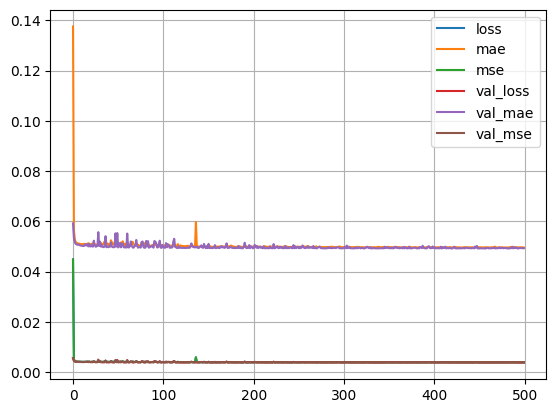

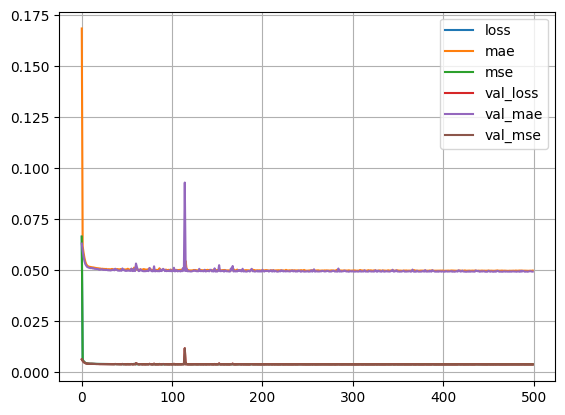

In [ ]:
hpd = pd.DataFrame(history.history)

hpd.plot()
plt.grid(True)
plt.show()

625/625 [==============================] - 1s 2ms/step


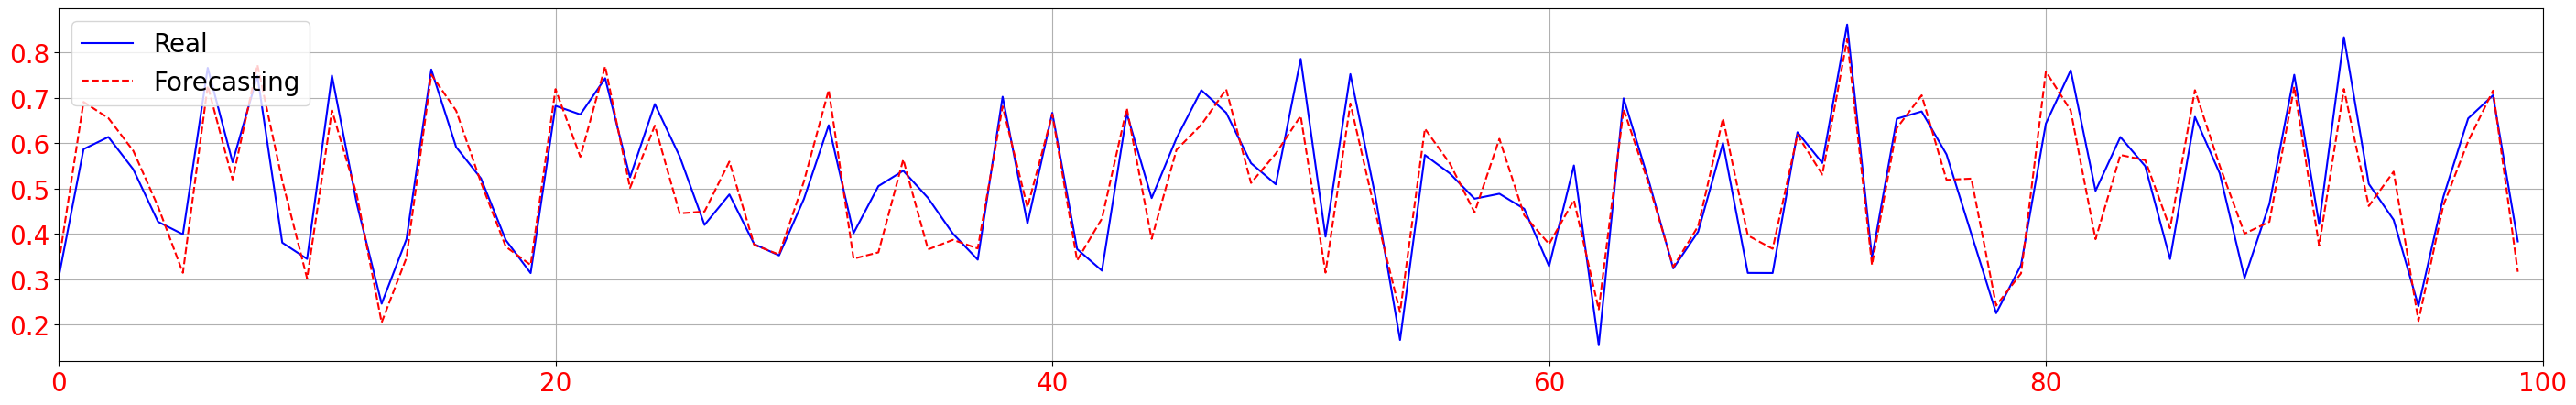

625/625 [==============================] - 1s 2ms/step


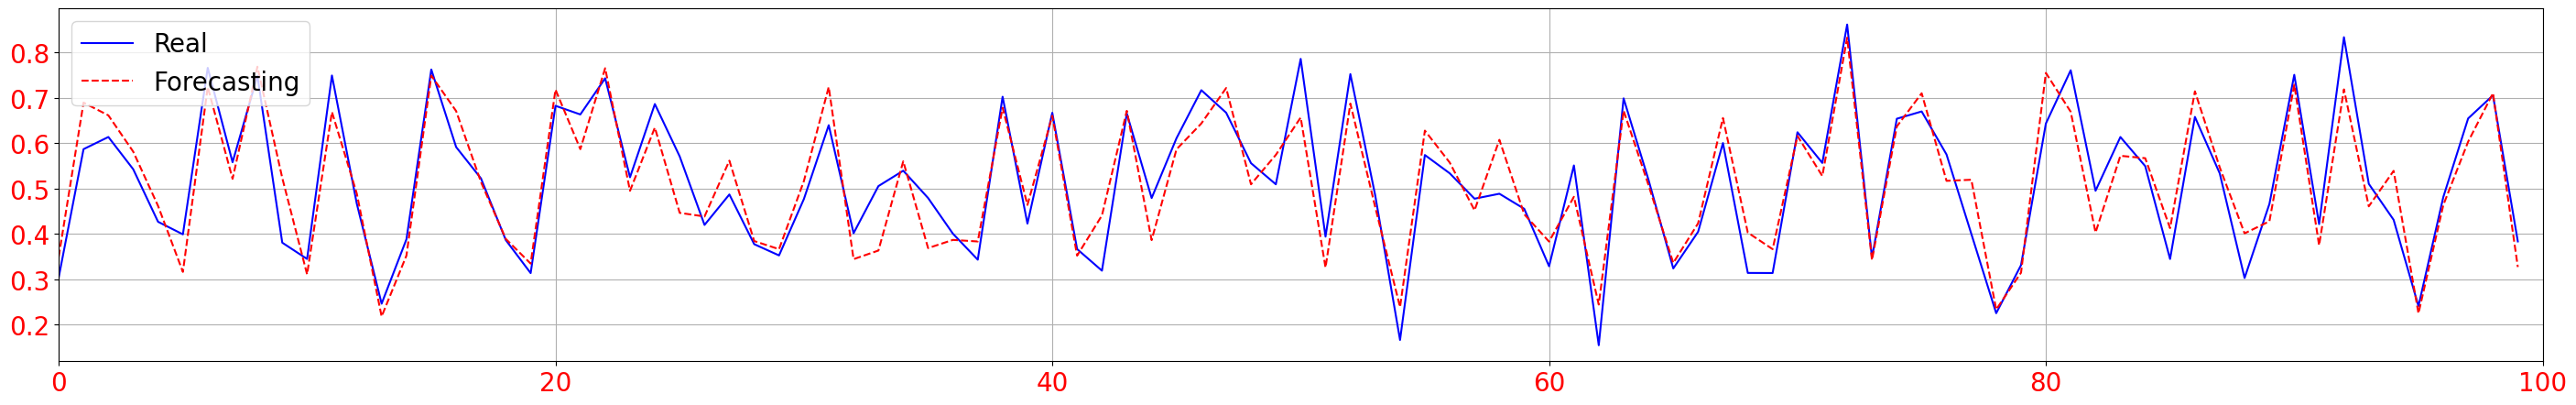

In [ ]:
forecasting_RFF_CNN1d = model.predict(X_test)

plt.figure(figsize=(35,5))
plt.plot(y_test[0:100], c='b', label='Real')
plt.plot(forecasting_RFF_CNN1d[0:100], c='r', label='Forecasting', linestyle='--')
plt.xlim(0,100)
plt.xticks(c='r', fontsize="20")
plt.yticks(c='r', fontsize="20")
plt.grid(True)
plt.legend(fontsize="20", loc="upper left")
plt.show()

In [ ]:
col_names.append("RFF-CNN 1d W=True scale=False")
MSE.append(round(mean_squared_error(y_test, forecasting_RFF_CNN1d, squared=False), 4))
RMSE.append(round(mean_squared_error(y_test, forecasting_RFF_CNN1d, squared=True), 4))
MAE.append(round(mean_absolute_error(y_test, forecasting_RFF_CNN1d), 4))
R2.append(round(r2_score(y_test, forecasting_RFF_CNN1d), 4))

## RFF Convolutional 1d: W=True, scale=True

In [ ]:
input = tf.keras.layers.Input(shape=(X_train.shape[1],1), name='Input')

tmp = Conv1dRFF(output_dim, kernel_size=kernel_size, trainable_W=True, trainable_scale=True)(input)
tmp = tf.keras.layers.Flatten()(tmp)
tmp = tf.keras.layers.Dense(units=64, activation='relu',name='Dense_1')(tmp)
output = tf.keras.layers.Dense(units=1, activation='linear')(tmp)

model = tf.keras.Model(inputs=input, outputs=output)
model.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Input (InputLayer)          [(None, 15, 1)]           0         
                                                                 
 conv1d_rff_7 (Conv1dRFF)    (None, 13, 1000)          4001      
                                                                 
 flatten_7 (Flatten)         (None, 13000)             0         
                                                                 
 Dense_1 (Dense)             (None, 64)                832064    
                                                                 
 dense_7 (Dense)             (None, 1)                 65        
                                                                 
Total params: 836130 (3.19 MB)
Trainable params: 836130 (3.19 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Model: "model_13"
____

In [ ]:
model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae', 'mse'])
history = model.fit(X_train, y_train, epochs=epochs, batch_size=1024, validation_data=(X_valid, y_valid), verbose=0)

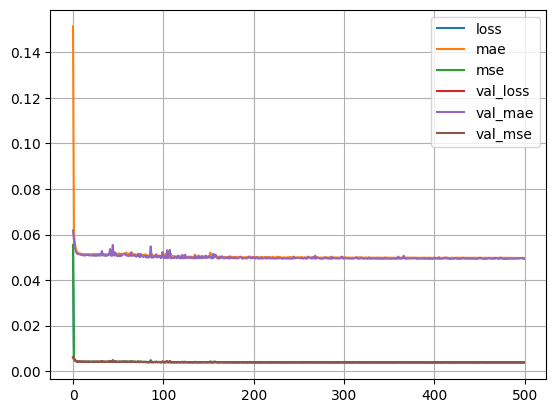

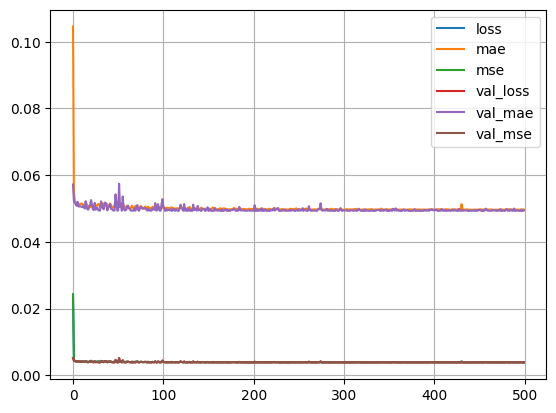

In [ ]:
hpd = pd.DataFrame(history.history)

hpd.plot()
plt.grid(True)
plt.show()

625/625 [==============================] - 1s 2ms/step


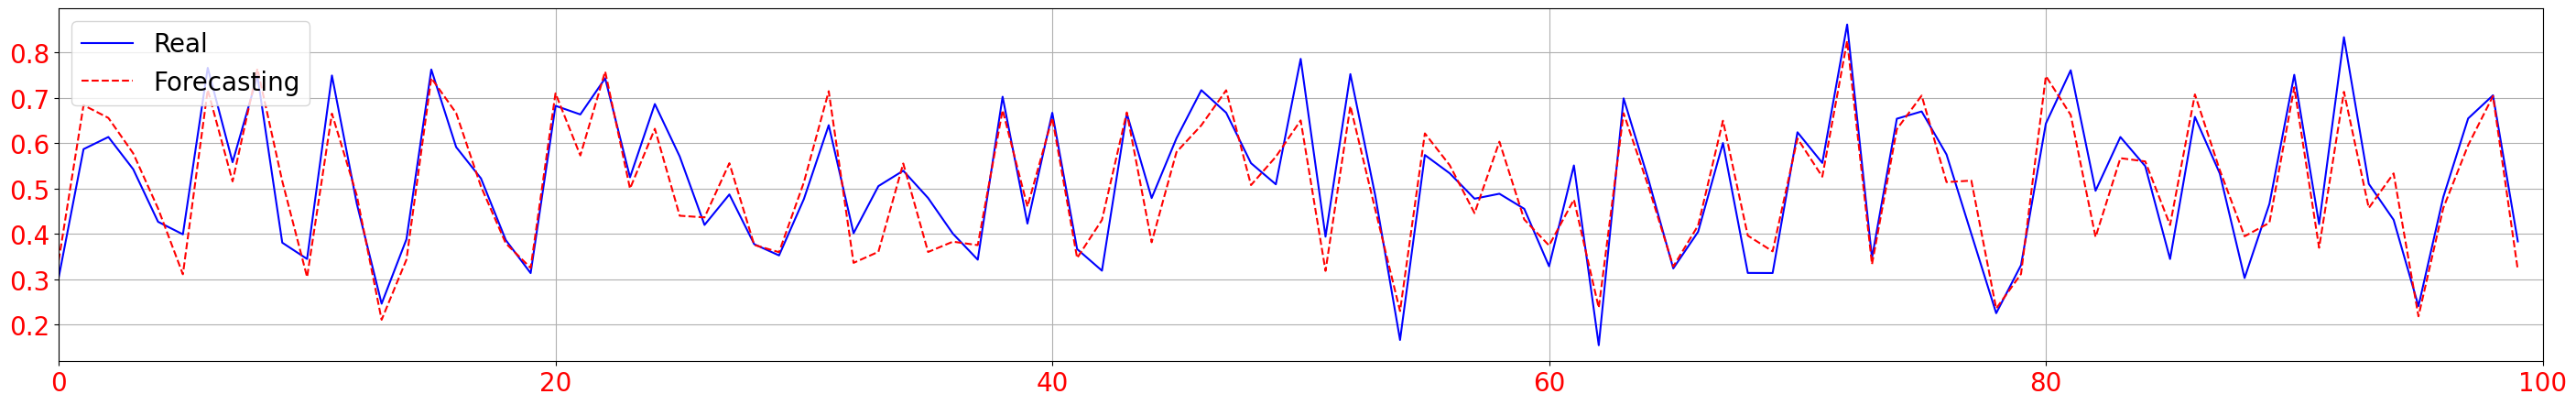

625/625 [==============================] - 2s 3ms/step


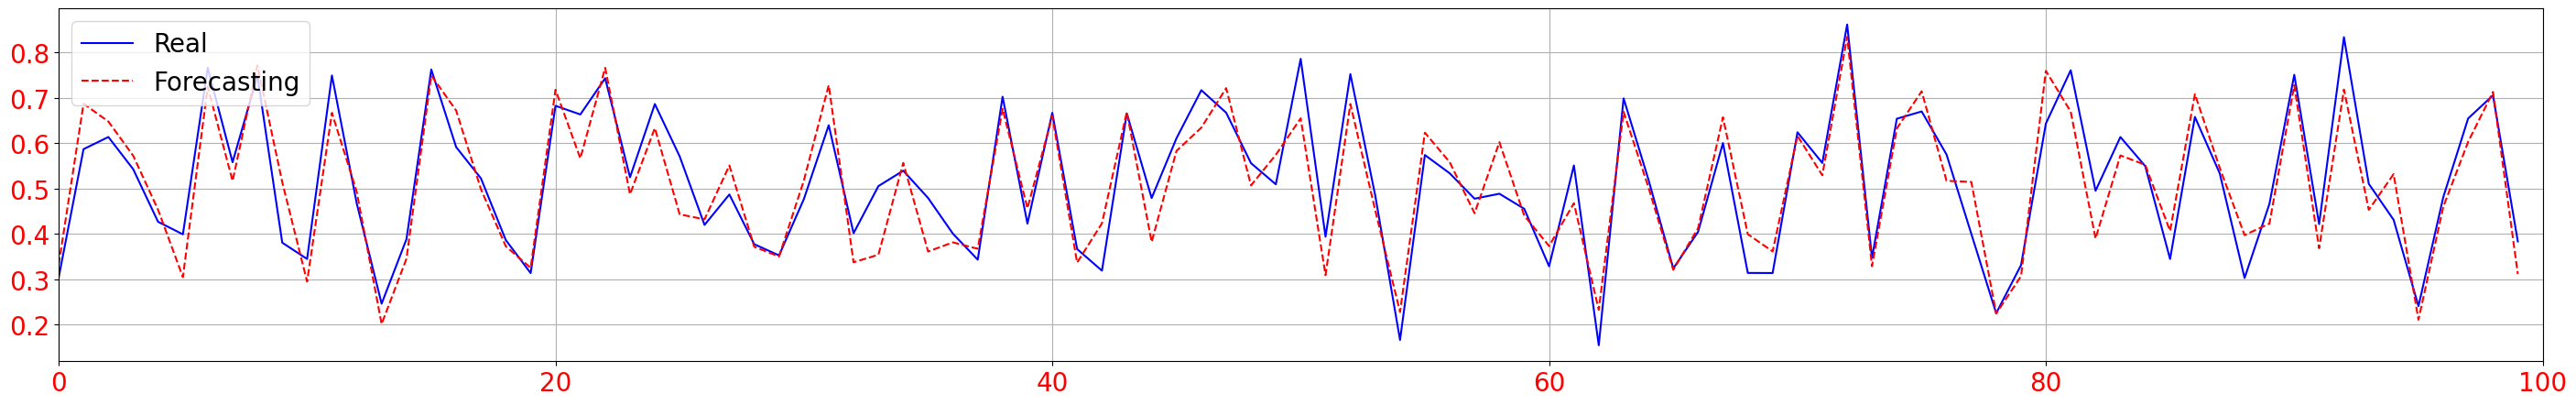

In [ ]:
forecasting_RFF_CNN1d = model.predict(X_test)

plt.figure(figsize=(35,5))
plt.plot(y_test[0:100], c='b', label='Real')
plt.plot(forecasting_RFF_CNN1d[0:100], c='r', label='Forecasting', linestyle='--')
plt.xlim(0,100)
plt.xticks(c='r', fontsize="20")
plt.yticks(c='r', fontsize="20")
plt.grid(True)
plt.legend(fontsize="20", loc="upper left")
plt.show()

In [ ]:
col_names.append("RFF-CNN 1d W=True scale=True")
MSE.append(round(mean_squared_error(y_test, forecasting_RFF_CNN1d, squared=False), 4))
RMSE.append(round(mean_squared_error(y_test, forecasting_RFF_CNN1d, squared=True), 4))
MAE.append(round(mean_absolute_error(y_test, forecasting_RFF_CNN1d), 4))
R2.append(round(r2_score(y_test, forecasting_RFF_CNN1d), 4))

#**Results**

In [ ]:
data = [MSE, RMSE, MAE, R2]

print(tabulate(data, headers=col_names, tablefmt="fancy_grid"))

╒═════════╤══════════╤══════════════════════════════════╤═════════════════════════════════╤═════════════════════════════════╤════════════════════════════════╕
│ Model   │   CNN 1d │   RFF-CNN 1d W=False scale=False │   RFF-CNN 1d W=False scale=True │   RFF-CNN 1d W=True scale=False │   RFF-CNN 1d W=True scale=True │
╞═════════╪══════════╪══════════════════════════════════╪═════════════════════════════════╪═════════════════════════════════╪════════════════════════════════╡
│ MSE     │    0.064 │                           0.0623 │                          0.0629 │                          0.0619 │                         0.0619 │
├─────────┼──────────┼──────────────────────────────────┼─────────────────────────────────┼─────────────────────────────────┼────────────────────────────────┤
│ RMSE    │    0.004 │                           0.0039 │                          0.004  │                          0.0038 │                         0.0038 │
├─────────┼──────────┼────────────────────────